# Goal
Evaluate the relationship between the [apestake.io](https://app.apestake.io/pools) $APE staking pools and their overall TVL and the average daily $APE price.

## Background
After [visualizing the trend for the $APE staking pools TVL and $APE price](https://dune.com/vivianu/dollarape-staking-tvl-vs-dollarape-price), an assumption was shaped that the TVL and token price are not strongly correlated. To check this assumption, the below correlation analysis was conducted, using Spearman correlation for not normally distributed numeric data with non-linear relationship.

In [22]:
# importing libs/modules and loading dotenv

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from dune_client.client import DuneClient

load_dotenv()

True

## Correlation matrix

First, let's build a correlation matrix to see how each of the staking pools, as well as the total TVL, correlate with the daily average $APE price.

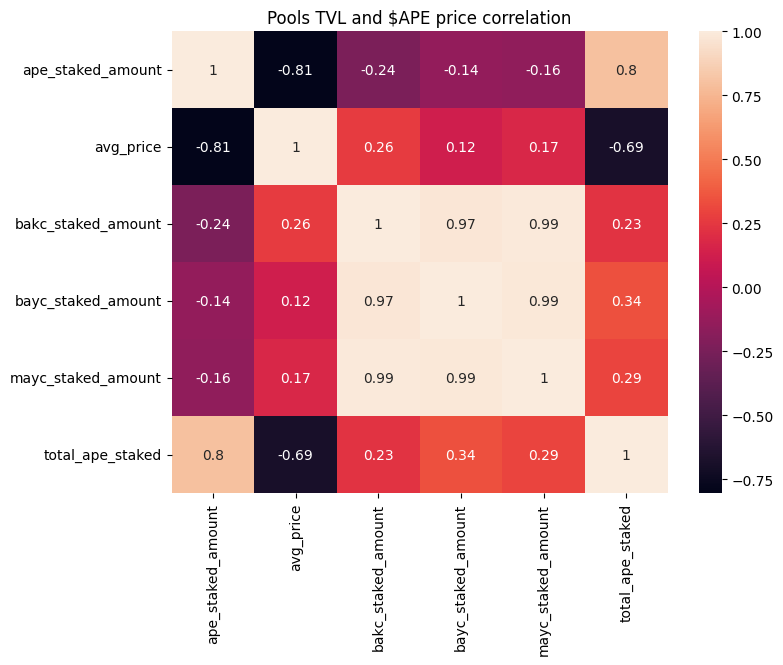

In [23]:
# fetching data
dune = DuneClient(os.getenv("DUNE_API_KEY")) # make sure you use your api key
response = dune.get_custom_endpoint_result(
    os.getenv("DUNE_USERNAME"), # make sure you use your username
    "apestake-tvl-vs-ape-price" # this is the custom endpoint
)

# converting response into dataframe
df = pd.DataFrame.from_records(response.result.rows)
df[['total_ape_staked', 'ape_staked_amount', 'bayc_staked_amount', 'mayc_staked_amount', 'bakc_staked_amount']] = df[['total_ape_staked', 'ape_staked_amount', 'bayc_staked_amount', 'mayc_staked_amount', 'bakc_staked_amount']].astype(float)

# creating & displaying correlation matrix
corr_matrix = df.corr(method='spearman', numeric_only=True)
plt.figure(figsize=(8, 6))
plt.title('Pools TVL and $APE price correlation')
sns.heatmap(corr_matrix, annot=True)
plt.show()

**-0.69** is a strong negative correlation between total $APE staked across the pools (`total_ape_staked`) and average daily $APE price (`avg_price`), meaning that $APE price tends to decrease with the increase in the TVL across the pools. At first, it doesn't make any sense, because staking pools exist for locking a share of circulating supply and should naturally decrease the sell pressure.

What's also interesting is that the $APE staking pool (`ape_staked_amount`) negatively correlates with the $APE price even stronger **(-0.81)**, while other pools have a weak correlation with the price.

This outcome can signal about more significant factors, negating the staking pools impact on the $APE price. Otherwise, the correlation should naturally be positive. Before contemplating on those other factors, let's check the statistical significance of these relationships to make sure they are not a product of chance.

## Statistical significance of relashionships

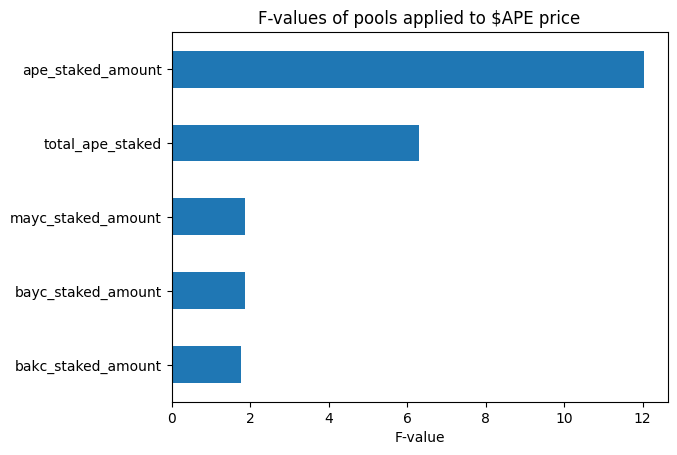

In [24]:
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import f_classif

df_copy = df.copy()
df_copy['avg_price'] = df_copy['avg_price'].apply(lambda x: round(x, 2))

# scaling factors to avoid bias towards larger numbers
scaler = RobustScaler()
cols_to_scale = ['total_ape_staked', 'ape_staked_amount', 'bayc_staked_amount', 'mayc_staked_amount', 'bakc_staked_amount']
df_copy[cols_to_scale] = scaler.fit_transform(df_copy[cols_to_scale])

# X include pool TVLs as factors, y include $APE prices as target variable
X = df_copy.drop(columns=['day', 'avg_price'])
y = df_copy['avg_price']

# visualizing F-values of pool TVLs applied to $APE price
f_pools = pd.Series(f_classif(X, y)[0], index=X.columns)
f_pools.sort_values(inplace=True)
f_pools.plot(kind='barh')
plt.title('F-values of pools applied to $APE price')
plt.xlabel('F-value')
plt.show();

Think of F-values as "how much the changes in this pool's TVL explain the changes in $APE price". The larger the `F-value`, the better the changes in the $APE price can be explained by the changes in the pool's TVL.

The second piece of the puzzle is to calculate a `critical F-value` which we will compare each pool's `F-value` against. Think of the `critical F-value` as the benchmark: if a pool's `F-value >= critical F-value`, then this pool TVL's relashionship to the $APE price is statistically significant.

In [36]:
from scipy.stats import f

# defining degrees of freedom
dfn = X.shape[1] - 1
dfd = X.shape[0] - X.shape[1]

# will be testing at the 0.05 significance level
alpha = 0.05

# calculating critical F-value
f_critical = f.ppf(1 - alpha, dfn, dfd)

# comparing each of the pools' F-values with the critical F-value
significant_pools = []
for pool_name, f_value in f_pools.items():
    if f_value >= f_critical:
        significant_pools.append(pool_name)
        
print('Pools with statistically significant relashionships to the $APE price at alpha = {}: {}'.format(alpha, ', '.join(significant_pools)))

Pools with statistically significant relashionships to the $APE price at alpha = 0.05: total_ape_staked, ape_staked_amount


The only pool with a significant level of relashionship to the $APE price is the $APE pool. The one which doesn't require any NFTs, and hence the most popular one amongst retail $APE investors. 

Since this pool is responsible for the most of the overall TVL fluctuation (as can be seen in [the Dune dashboard](https://dune.com/vivianu/dollarape-staking-tvl-vs-dollarape-price)), the overall TVL factor is also statistically significant when it comes to the $APE price.

# Conclusion

There is a statistically significant strong negative correlation between the overall $APE TVL across [the apestake.io pools](https://app.apestake.io/pools) and the daily average $APE price. The top contributor to this relashionship is the $APE staking pool. Again, the fact that the higher TVL, the lower the $APE price doesn't make sense unless considered in a broader context.

It can rather be a signal that, despite staking pools do reduce the token circulating supply and decrease the sell pressure, other stronger factors still decrease the $APE price. And these factors, including $APE faucets and sinks, should be the area of further research.

# Further research
- Create a list of $APE faucets and sinks throughout $APE lifetime;
- For each faucet & sink, calculate the token flow;
- Aggregate token flows together and run a similar analysis to identify which flows contribute to the $APE price changes the most. This will allow to identify the most effective faucets and sinks for $APE. The understanding of what faucets and sinks work the best can help shape both the $APE tokenomics roadmap as well as tokenomics of other cultural tokens.